MERGE

In [1]:
import os
import shutil

In [2]:
def getAllFilesInDirectoryAndSubdirectories(directory):
    filelist = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            filelist.append(os.path.join(root,file))
    return filelist

In [3]:
import glob
import shutil

def mergeOnlyPlans(sourceDirs, outDir, useid = False):
    if useid:
        idFile = open(os.path.join(outDir, "id_merged.csv" ), "a")
    for sd in sourceDirs:
        for file in glob.glob(sd + "/*_explain.txt"):
            shutil.copy(file, outDir)
        if useid:
            with open(glob.glob(sd+"/id_*")[0]) as ids:
                for line in ids:
                    if "ts" in line:
                        idFile.write(line.strip() + "\n")
                          
              

In [4]:
subDirs = [f.path for f in os.scandir("./out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/") if f.is_dir()]
subDirs

['./out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/3',
 './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/5',
 './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/4',
 './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/1',
 './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/2']

In [5]:
srcDirs = []
for dir in subDirs:
    srcDirs.append([x[0] for x in os.walk(dir)][1:])
    srcDirs[-1].sort()

srcDirs

[['./out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/3/2023-09-26_09:52:03.758126',
  './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/3/2023-09-26_09:53:01.533203',
  './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/3/2023-09-26_09:53:54.068509'],
 ['./out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/5/2023-09-26_09:55:30.289889',
  './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/5/2023-09-26_09:56:27.645156',
  './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/5/2023-09-26_09:57:19.505260'],
 ['./out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/4/2023-09-26_09:54:10.318351',
  './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/4/2023-09-26_09:55:13.702154'],
 ['./out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/1/2023-09-26_09:46:58.090169',
  './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/1/2023-09-26_09:47:56.109630',
  './out/runYan_secondaryPlans_revised_20230926_onlyPlan/full/1/202

In [6]:
from pathlib import Path
i = 1
for d in srcDirs:
    Path("./mergeout/secondaryPlans_revised/"+str(i)).mkdir(parents=True, exist_ok=True)
    mergeOnlyPlans(d, "./mergeout/secondaryPlans_revised/"+str(i), useid = True)
    i = i + 1

EVALUATE

In [7]:
import glob
import numpy as np

In [8]:
def openFileByWildcard(wc):
  for filename in glob.glob(wc):
    f = open(filename, 'r')
    return f

In [9]:
def parseµms(s):
    if "µs" in s:
        s = s.replace("µs", "").strip()
        return float(s)/1000
    if "ms" in s:
        s = s.replace("ms", "").strip()
        return float(s)
    if "s" in s:
        s = s.replace("s", "").strip()
        return float(s)*1000

In [10]:
def getCosts(mergedir, logfile):
    # get queries and timestamps into the two lists
    idFile = openFileByWildcard(os.path.join(mergedir, "id*"))
    queries = []
    timestamps = []
    costbefore = []
    costafter = []
    duration = []
    planning = []
    lines = []
    queriesToRemove = []
    for idline in idFile.readlines():
        parts = idline.replace("/*", "").replace("*/", "").split(",")
        query = parts[0].split("/")[-1].replace(".sql", "").strip()
        ts = parts[1].split(":")[1].strip()
        queries.append(query)
        timestamps.append(ts)

    queryid = 0
    started = False
    buffer = [""]*20
    with open(logfile, "r") as log:
        while queryid < len(queries):
            l = log.readline()
            if not l:
                break
            
            if "YAN secondary plans" in l and started:
                qstart = l.find('orig_queries/') + len('orig_queries/')
                qend = l.find('.sql', qstart)
                
                if l[qstart:qend] > queries[queryid]:
                    queriesToRemove.append(queries[queryid])
                    queryid = queryid + 1
           
            if "YAN secondary plans" in l and "final cost" in l and timestamps[queryid] in l and queries[queryid] in l: # todo: skip if there is no entry/no second entry
                started = True
                coststart = l.find('cost:') + len('cost:')
                costend = l.find(',', coststart)

                # go back for planning time, init cost
                end = 0
                for li in buffer:
                    if "Time since start excluding secondaries" in li:
                        tstart = li.find('Time since start excluding secondaries:') + len('Time since start excluding secondaries:')
                        tend = li.find('"', tstart)
                        planning.append(end - parseµms(li[tstart:tend].strip()))
                        break

                    elif "Time since start including secondaries" in li:
                        tstart = li.find('Time since start including secondaries:') + len('Time since start including secondaries:')
                        tend = li.find('"', tstart)
                        end = parseµms(li[tstart:tend].strip())

                    elif "initial cost" in li:
                        costbefstart = li.find('cost:') + len('cost:')
                        costbefend = li.find(',', costbefstart)
                        costbefore.append(float(li[costbefstart:costbefend].strip()))
                        lines.append(li)
                        

                
                costafter.append(float(l[coststart:costend].strip()))
                durstart = l.find("took:", costend) + len("took:")
                durend = l.find(",", durstart)
                duration.append(parseµms(l[durstart:durend].strip()))
                lines.append(l)
                    
                queryid = queryid + 1
            buffer.insert(0,l)
            buffer = buffer[0:20]
    return (queries, costbefore, costafter, duration, lines, planning, queriesToRemove)

In [11]:
allqueries = []
allcostbefore = []
allcostafter = []
allduration = []
alllines = []
allplanning = []
allqueriestoremove = []
for i in range(1,6):
    queries, costbefore, costafter, duration, lines, planning, queriesToRemove = getCosts("./mergeout/secondaryPlans_revised/" + str(i) + "/", "./tidb_IP_4000_secondaryPlans_revised.log")
    queries = [q for q in queries if q not in queriesToRemove]
    print(queriesToRemove)
    print(queries)
    allqueries.append(queries)
    allcostbefore.append(costbefore)
    allcostafter.append(costafter)
    allduration.append(duration)
    alllines.append(lines)
    allplanning.append(planning)
    allqueriestoremove.append(queriesToRemove)

    init = True
    for l in lines:
        if init and "initial" in l:
            init = False
        elif not init and "final" in l:
            init = True
        else:
            print("=====================ERROR")
            print(l)

['23ao', '28ab']
['02aa', '02ab', '02ac', '02ad', '02ae', '02af', '02ag', '02ah', '02ai', '02aj', '02ak', '02al', '02am', '02an', '02ao', '03aa', '03ab', '03ac', '03ad', '03ae', '03af', '03ag', '03ah', '03ai', '03aj', '03ak', '03al', '03am', '03an', '03ao', '04aa', '04ab', '04ac', '04ad', '04ae', '04af', '04ag', '04ah', '04ai', '04aj', '04ak', '04al', '04am', '04an', '04ao', '05aa', '05ab', '05ac', '05ad', '05ae', '05af', '05ag', '05ah', '05ai', '05aj', '05ak', '05al', '05am', '05an', '05ao', '06aa', '06ab', '06ac', '06ad', '06ae', '06af', '06ag', '06ah', '06ai', '06aj', '06ak', '06al', '06am', '06an', '06ao', '07aa', '07ab', '07ac', '07ad', '07ae', '07af', '07ag', '07ah', '07ai', '07aj', '07ak', '07al', '07am', '07an', '07ao', '08aa', '08ab', '08ac', '08ad', '08ae', '08af', '08ag', '08ah', '08ai', '08aj', '08ak', '08al', '08am', '08an', '08ao', '09aa', '09ab', '09ac', '09ad', '09ae', '09af', '09ag', '09ah', '09ai', '09aj', '09ak', '09al', '09am', '09an', '09ao', '10aa', '10ab', '10ac'

In [12]:
def getDiffPercentage(costbefore, costafter):
    diffPercentage = []
    for i in range(len(costbefore)):
        diffPercentage.append((1-(costafter[i]/costbefore[i]))*100)
    #diffPercentage
    #np.median(diffPercentage)
    #len(diffPercentage) - np.count_nonzero(diffPercentage)
    return diffPercentage

In [13]:
queries = ['02aa', '02ab', '02ac', '02ad', '02ae', '02af', '02ag', '02ah', '02ai', '02aj', '02ak', '02al', '02am', '02an', '02ao', '03aa', '03ab', '03ac', '03ad', '03ae', '03af', '03ag', '03ah', '03ai', '03aj', '03ak', '03al', '03am', '03an', '03ao', '04aa', '04ab', '04ac', '04ad', '04ae', '04af', '04ag', '04ah', '04ai', '04aj', '04ak', '04al', '04am', '04an', '04ao', '05aa', '05ab', '05ac', '05ad', '05ae', '05af', '05ag', '05ah', '05ai', '05aj', '05ak', '05al', '05am', '05an', '05ao', '06aa', '06ab', '06ac', '06ad', '06ae', '06af', '06ag', '06ah', '06ai', '06aj', '06ak', '06al', '06am', '06an', '06ao', '07aa', '07ab', '07ac', '07ad', '07ae', '07af', '07ag', '07ah', '07ai', '07aj', '07ak', '07al', '07am', '07an', '07ao', '08aa', '08ab', '08ac', '08ad', '08ae', '08af', '08ag', '08ah', '08ai', '08aj', '08ak', '08al', '08am', '08an', '08ao', '09aa', '09ab', '09ac', '09ad', '09ae', '09af', '09ag', '09ah', '09ai', '09aj', '09ak', '09al', '09am', '09an', '09ao', '10aa', '10ab', '10ac', '10ad', '10ae', '10af', '10ag', '10ah', '10ai', '10aj', '10ak', '10al', '10am', '10an', '10ao', '11aa', '11ab', '11ac', '11ad', '11ae', '11af', '11ag', '11ah', '11ai', '11aj', '11ak', '11al', '11am', '11an', '11ao', '12aa', '12ab', '12ac', '12ad', '12ae', '12af', '12ag', '12ah', '12ai', '12aj', '12ak', '12al', '12am', '12an', '12ao', '13aa', '13ab', '13ac', '13ad', '13ae', '13af', '13ag', '13ah', '13ai', '13aj', '13ak', '13al', '13am', '13an', '13ao', '14aa', '14ab', '14ac', '14ad', '14ae', '14af', '14ag', '14ah', '14ai', '14aj', '14ak', '14al', '14am', '14an', '14ao', '15aa', '15ab', '15ac', '15ad', '15ae', '15af', '15ag', '15ah', '15ai', '15aj', '15ak', '15al', '15am', '15an', '15ao', '16aa', '16ab', '16ac', '16ad', '16ae', '16af', '16ag', '16ah', '16ai', '16aj', '16ak', '16al', '16am', '16an', '16ao', '17aa', '17ab', '17ac', '17ad', '17ae', '17af', '17ag', '17ah', '17ai', '17aj', '17ak', '17al', '17am', '17an', '17ao', '18aa', '18ab', '18ac', '18ad', '18ae', '18af', '18ag', '18ah', '18ai', '18aj', '18ak', '18al', '18am', '18an', '18ao', '19aa', '19ab', '19ac', '19ad', '19ae', '19af', '19ag', '19ah', '19ai', '19aj', '19ak', '19al', '19am', '19an', '19ao', '20aa', '20ab', '20ac', '20ad', '20ae', '20af', '20ag', '20ah', '20ai', '20aj', '20ak', '20al', '20am', '20an', '20ao', '21aa', '21ab', '21ac', '21ad', '21ae', '21af', '21ag', '21ah', '21ai', '21aj', '21ak', '21al', '21am', '21an', '21ao', '22aa', '22ab', '22ac', '22ad', '22ae', '22af', '22ag', '22ah', '22ai', '22aj', '22ak', '22al', '22am', '22an', '22ao', '23aa', '23ab', '23ac', '23ad', '23ae', '23af', '23ag', '23ah', '23ai', '23aj', '23ak', '23al', '23am', '23an', '23ao', '24aa', '24ab', '24ac', '24ad', '24ae', '24af', '24ag', '24ah', '24ai', '24aj', '24ak', '24al', '24am', '24an', '24ao', '25aa', '25ab', '25ac', '25ad', '25ae', '25af', '25ag', '25ah', '25ai', '25aj', '25ak', '25al', '25am', '25an', '25ao', '26aa', '26ab', '26ac', '26ad', '26ae', '26af', '26ag', '26ah', '26ai', '26aj', '26ak', '26al', '26am', '26an', '26ao', '27aa', '27ab', '27ac', '27ad', '27ae', '27af', '27ag', '27ah', '27ai', '27aj', '27ak', '27al', '27am', '27an', '27ao', '28aa', '28ab', '28ac', '28ad', '28ae', '28af', '28ag', '28ah', '28ai', '28aj', '28ak', '28al', '28am', '28an', '28ao', '29aa', '29ab', '29ac', '29ad', '29ae', '29af', '29ag', '29ah', '29ai', '29aj', '29ak', '29al', '29am', '29an', '29ao', '30aa', '30ab', '30ac', '30ad', '30ae', '30af', '30ag', '30ah', '30ai', '30aj', '30ak', '30al', '30am', '30an', '30ao']

overlap = [q for q in queries if q not in allqueries[0]]
for i in range(1,5):
    newmissingq = [q for q in queries if q not in allqueries[i]]
    overlap = [value for value in overlap if value in newmissingq]
overlap # --> some overlap

['28ab']

In [14]:
import matplotlib.pyplot as plt

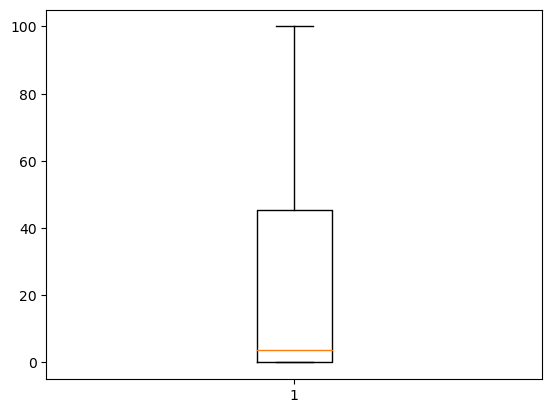

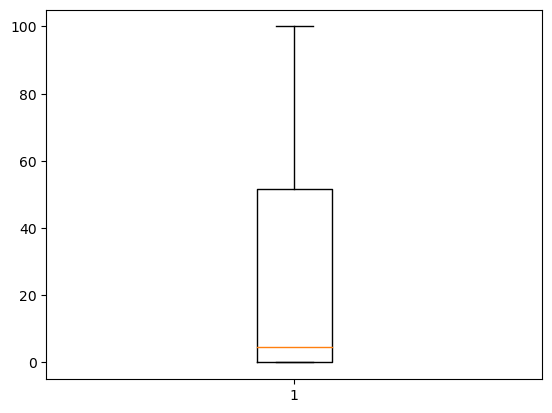

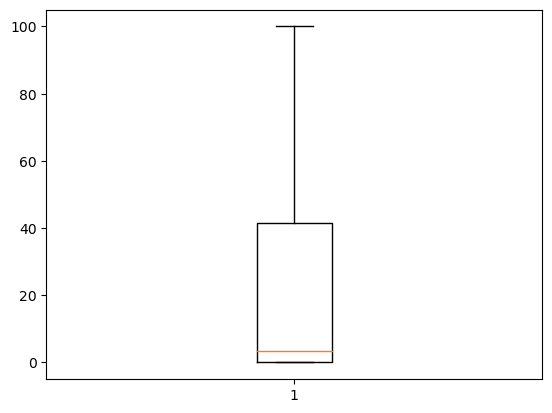

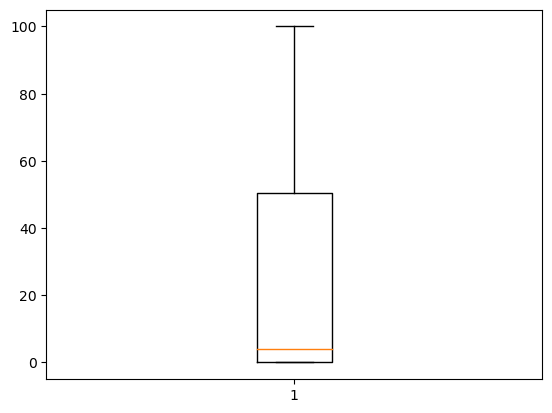

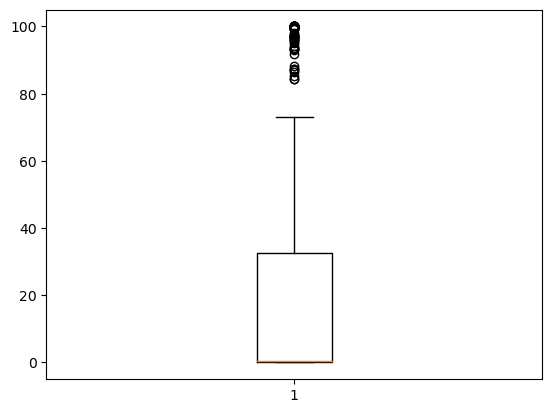

In [15]:
for i in range(5):
    fig = plt.figure()
    plt.boxplot(getDiffPercentage(allcostbefore[i], allcostafter[i]), notch=None, vert=None, patch_artist=None, widths=None)

In [16]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [17]:
improvcounters = []
notsolved = []
solved = []
avgs = []
medians = []
maxs = []
mins = []
avgs1 = []
medians1 = []
avgs2 = []
medians2 = []
avgs3 = []
medians3 = []
duravgs = []
durmedians = []
durmaxs = []
durmins = []
duravgs1 = []
durmedians1 = []
duravgs2 = []
durmedians2 = []
duravgs3 = []
durmedians3 = []
for i in range(5):
    counter = 0
    for j in range(len(allcostbefore[i])):
        if allcostbefore[i][j] > allcostafter[i][j]:
            counter = counter + 1
    improvcounters.append(counter)
    diffs = getDiffPercentage(allcostbefore[i], allcostafter[i])
    notsolved.append(435 - len(allqueries[i]))
    solved.append(len(allqueries[i]))
    avgs.append(np.average(diffs))
    medians.append(np.median(diffs))
    maxs.append(np.max(diffs))
    mins.append(np.min(diffs))
    diffparts = list(split(diffs, 3))
    avgs1.append(np.average(diffparts[0]))
    medians1.append(np.median(diffparts[0]))
    avgs2.append(np.average(diffparts[1]))
    medians2.append(np.median(diffparts[1]))
    avgs3.append(np.average(diffparts[2]))
    medians3.append(np.median(diffparts[2]))
    dur = [sum(x) for x in zip(allplanning[i], allduration[i])]
    duravgs.append(np.average(dur))
    durmedians.append(np.median(dur))
    durmaxs.append(np.max(dur))
    durmins.append(np.min(dur))
    durp = list(split(dur, 3))
    duravgs1.append(np.average(durp[0]))
    durmedians1.append(np.median(durp[0]))
    duravgs2.append(np.average(durp[1]))
    durmedians2.append(np.median(durp[1]))
    duravgs3.append(np.average(durp[2]))
    durmedians3.append(np.median(durp[2]))
    
print("Improved", improvcounters)
print("Unsolved", notsolved)
print("Solved", solved)
print("Avgs",avgs)
print("Medians",medians)
print("Maxs",maxs)
print("Mins",mins)
print("Avgs1",avgs1) # first third of the queries
print("Medians1",medians1)
print("Avgs2",avgs2) # second third of the queries
print("Medians2",medians2)
print("Avgs3",avgs3) # third third of the queries
print("Medians3",medians3)
print("Dur Avgs",duravgs)
print("Dur Medians",durmedians)
print("Dur Maxs",durmaxs)
print("Dur Mins",durmins)
print("Dur Avgs1",duravgs1) # first third of the queries
print("Dur Medians1",durmedians1)
print("Dur Avgs2",duravgs2) # second third of the queries
print("Dur Medians2",durmedians2)
print("Dur Avgs3",duravgs3) # third third of the queries
print("Dur Medians3",durmedians3)

Improved [256, 267, 264, 268, 233]
Unsolved [2, 2, 1, 3, 6]
Solved [433, 433, 434, 432, 429]
Avgs [27.00787424851581, 27.850529197552504, 26.055446349363226, 27.972341211187928, 23.40005708247208]
Medians [3.6546561247634335, 4.472208067555128, 3.403861818630877, 4.061994697016896, 0.5380935711560508]
Maxs [100.0, 100.0, 100.0, 100.0, 100.0]
Mins [0.0, 0.0, 0.0, 0.0, 0.0]
Avgs1 [5.798041819503667, 8.267676888143177, 7.624255426345161, 8.298253099986276, 5.624252778806042]
Medians1 [0.0, 0.0, 0.0, 0.06940198522005225, 0.0]
Avgs2 [32.77137529483178, 27.94205544262951, 28.863129603970673, 24.847925537997796, 25.36996174654889]
Medians2 [14.78716058251191, 7.618975446919007, 8.379140786419349, 3.1557153114954275, 1.9103988692105611]
Avgs3 [42.60149613419123, 47.47784729181128, 41.78745059880449, 50.77084499557971, 39.205956722061316]
Medians3 [22.91398143896215, 43.286784937024464, 20.459172883251107, 47.30877566719394, 9.672138974596244]
Dur Avgs [25.510193108545035, 21.7225022147806, 22.